<a href="https://colab.research.google.com/github/k-nai/sandbox_pytorch_advanced_learning/blob/main/1_image_classification/1_1_load_VGG_16_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 「第1章 画像分類」


## データの準備

In [1]:
import os
import urllib.request
import zipfile

In [2]:
# フォルダ「data」が存在しない場合は作成する
data_dir = "./data/"
if not os.path.exists(data_dir):
    os.mkdir(data_dir)


In [3]:
# ImageNetのclass_indexをダウンロードする
# Kerasで用意されているものです
# https://github.com/fchollet/deep-learning-models/blob/master/imagenet_utils.py

url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
save_path = os.path.join(data_dir, "imagenet_class_index.json")

if not os.path.exists(save_path):
    urllib.request.urlretrieve(url, save_path)


In [5]:
# 1.3節で使用するアリとハチの画像データをダウンロードし解凍します
# PyTorchのチュートリアルで用意されているものです
# https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

url = "https://download.pytorch.org/tutorial/hymenoptera_data.zip"
save_path = os.path.join(data_dir, "hymenoptera_data.zip")

if not os.path.exists(save_path):
    urllib.request.urlretrieve(url, save_path)

    # ZIPファイルを読み込み
    zip = zipfile.ZipFile(save_path)
    zip.extractall(data_dir)  # ZIPを解凍
    zip.close()  # ZIPファイルをクローズ

    # ZIPファイルを消去
    os.remove(save_path)


## 1-1. 学習済みモデルの使用

In [6]:
# パッケージのimport
import numpy as np
import json
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torchvision
from torchvision import models, transforms

In [7]:
# PyTorchのバージョン確認
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.12.1+cu113
Torchvision Version:  0.13.1+cu113


In [8]:
# 学習済みのVGG-16モデルをロード
# 初めて実行する際は、学習済みパラメータをダウンロードするため、実行に時間がかかります

# VGG-16モデルのインスタンスを生成
use_pretrained = True  # 学習済みのパラメータを使用
net = models.vgg16(pretrained=use_pretrained)
net.eval()  # 推論モードに設定

# モデルのネットワーク構成を出力
print(net)


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### 入力画像の前処理

In [9]:
# 入力画像の前処理のクラス
class BaseTransform():
    """
    画像のサイズをリサイズし、色を標準化する。

    Attributes
    ----------
    resize : int
        リサイズ先の画像の大きさ。
    mean : (R, G, B)
        各色チャネルの平均値。
    std : (R, G, B)
        各色チャネルの標準偏差。
    """

    def __init__(self, resize, mean, std):
        self.base_transform = transforms.Compose([
            transforms.Resize(resize),  # 短い辺の長さがresizeの大きさになる
            transforms.CenterCrop(resize),  # 画像中央をresize × resizeで切り取り
            transforms.ToTensor(),  # Torchテンソルに変換
            transforms.Normalize(mean, std)  # 色情報の標準化
        ])

    def __call__(self, img):
        return self.base_transform(img)

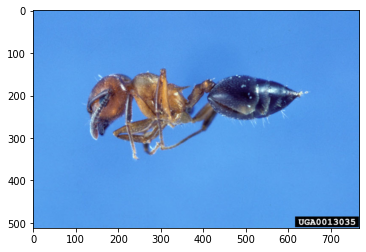

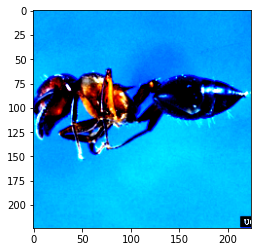

In [16]:
# 画像前処理の動作を確認

# 1. 画像読み込み
image_file_path = './data/hymenoptera_data/train/ants/0013035.jpg'
img = Image.open(image_file_path)  # [高さ][幅][色RGB]

# 2. 元の画像の表示
plt.imshow(img)
plt.show()

# 3. 画像の前処理と処理済み画像の表示
resize = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
transform = BaseTransform(resize, mean, std)
img_transformed = transform(img)  # torch.Size([3, 224, 224])

# (色、高さ、幅)を (高さ、幅、色)に変換し、0-1に値を制限して表示
img_transformed = img_transformed.numpy().transpose((1, 2, 0))
img_transformed = np.clip(img_transformed, 0, 1)
plt.imshow(img_transformed)
plt.show()

### 後処理のクラスを作成

出力結果から予測結果を予測する後処理を追加

In [15]:
# ILSVRCのラベル情報をロードし辞書型変数を生成します
ILSVRC_class_index = json.load(open('./data/imagenet_class_index.json', 'r'))
ILSVRC_class_index


{'0': ['n01440764', 'tench'],
 '1': ['n01443537', 'goldfish'],
 '2': ['n01484850', 'great_white_shark'],
 '3': ['n01491361', 'tiger_shark'],
 '4': ['n01494475', 'hammerhead'],
 '5': ['n01496331', 'electric_ray'],
 '6': ['n01498041', 'stingray'],
 '7': ['n01514668', 'cock'],
 '8': ['n01514859', 'hen'],
 '9': ['n01518878', 'ostrich'],
 '10': ['n01530575', 'brambling'],
 '11': ['n01531178', 'goldfinch'],
 '12': ['n01532829', 'house_finch'],
 '13': ['n01534433', 'junco'],
 '14': ['n01537544', 'indigo_bunting'],
 '15': ['n01558993', 'robin'],
 '16': ['n01560419', 'bulbul'],
 '17': ['n01580077', 'jay'],
 '18': ['n01582220', 'magpie'],
 '19': ['n01592084', 'chickadee'],
 '20': ['n01601694', 'water_ouzel'],
 '21': ['n01608432', 'kite'],
 '22': ['n01614925', 'bald_eagle'],
 '23': ['n01616318', 'vulture'],
 '24': ['n01622779', 'great_grey_owl'],
 '25': ['n01629819', 'European_fire_salamander'],
 '26': ['n01630670', 'common_newt'],
 '27': ['n01631663', 'eft'],
 '28': ['n01632458', 'spotted_salama

In [24]:
# 出力結果からラベルを予測する後処理クラス
class ILSVRCPredictor():
    """
    ILSVRCデータに対するモデルの出力からラベルを求める。

    Attributes
    ----------
    class_index : dictionary
            クラスindexとラベル名を対応させた辞書型変数。
    """

    def __init__(self, class_index):
        self.class_index = class_index

    def predict_max(self, out):
        """
        確率最大のILSVRCのラベル名を取得する。

        Parameters
        ----------
        out : torch.Size([1, 1000])
            Netからの出力。

        Returns
        -------
        predicted_label_name : str
            最も予測確率が高いラベルの名前
        """
        maxid = np.argmax(out.detach().numpy())
        predicted_label_name = self.class_index[str(maxid)][1]

        return predicted_label_name


### 予測処理

In [25]:
# ILSVRCのラベル情報をロードし辞意書型変数を生成します
ILSVRC_class_index = json.load(open('./data/imagenet_class_index.json', 'r'))

# ILSVRCPredictorのインスタンスを生成します
predictor = ILSVRCPredictor(ILSVRC_class_index)

# 入力画像を読み込む
image_file_path = './data/hymenoptera_data/train/ants/0013035.jpg'
img = Image.open(image_file_path)  # [高さ][幅][色RGB]

# 前処理の後、バッチサイズの次元を追加する
transform = BaseTransform(resize, mean, std)  # 前処理クラス作成
img_transformed = transform(img)  # torch.Size([3, 224, 224])
inputs = img_transformed.unsqueeze_(0)  # torch.Size([1, 3, 224, 224])

# モデルに入力し、モデル出力をラベルに変換する
out = net(inputs)  # torch.Size([1, 1000])
result = predictor.predict_max(out)

# 予測結果を出力する
print("入力画像の予測結果：", result)


torch.Size([1, 1000])
入力画像の予測結果： ant
